In [3]:
from expkit import ExpSetup,Exp, InstanceEval
from expkit.pexp import PExp
from expkit.ops import (
    EvalMean,
    EvalLast,
    EvalMax,
    EvalTotalMean,
    EvalMeanLast,
    EvalMeanMax,
    Operation,
    proj,
    OperationType,
)
from functools import partial
import numpy as np
import gc
# beta in used by the rlhf model: 0.0325
N = 1024
TEMP = 0.6
n=128
N_MEASURAMENTS=[1,2,4,8,16,32,64,128]
eval_key = "correctedqe:Unbabel-XCOMET-XL"
LP ="en-zh"


def nondiagmean(x):
    x = x.squeeze()
    return x.sum() / (
        x.shape[0] * (x.shape[0] - 1)
    )

In [6]:
setup = ExpSetup(
    "/gscratch/ark/graf/quest-decoding/examples/mt/mt-outputs/",
    lazy=True,
    load_instances=False,
    ops={
        "diversity": Operation(
            type=OperationType.EVAL,
            func=lambda instance_evals: np.mean(list(
                map(
                    lambda x: nondiagmean( 
                        np.array(x["scores"])),
                    instance_evals,
                )
            )),
            key="pairwise-bleu-repr",
        ),
        **{
            f"mean-reward-{n}": EvalTotalMean(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
        **{
            f"last-reward-{n}": EvalMeanLast(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
        **{
            f"max-reward-{n}": EvalMeanMax(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
    },
).query(
    {"steps": 128}
)

In [10]:
setup=setup.query({"language_pair": LP}).sort("at")

In [14]:
for exp in setup.experiments[::-1]:
    print(exp.name)
    print(exp.evals.keys())
    print(exp.meta["at"])
    print("--"*40)

8aa773ab-934e-4d2d-beda-9cac700062f8
dict_keys(['correctedqe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt23-cometkiwi-da-xl'])
2024-08-09T22:41:40.181304
--------------------------------------------------------------------------------
976e3b88-295d-4826-b639-ebafcbfba882
dict_keys(['correctedqe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt23-cometkiwi-da-xl'])
2024-08-09T18:04:52.561155
--------------------------------------------------------------------------------
e72e8c4e-c8fe-4867-a5c1-b1b8cea81101
dict_keys(['correctedqe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt23-cometkiwi-da-xl'])
2024-08-09T13:24:42.475300
--------------------------------------------------------------------------------
3f879ee6-2f62-45af-be05-f67da439ca42
dict_keys(['correctedqe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt23-cometkiwi-da-xl'])
2024-08-09T08:43:54.628760
--------------------------------------------------------------------------------
51259542-d435-43f4-9f40-eb6bcdbcf0aa
dict_keys(['correctedqe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt

In [99]:
base = setup.query(
    {
        "variant": "ancestral"#,"temperature":0.8
    }
)

quest = setup.query({"variant": "quest"})


print("---" * 20)
print(LP)
print("base")
print(
    len(
        base.meta()
    )
)
print(
    list(map(
        proj("temperature"),
        base.meta()
    ))
)
print("quest")
print(
    len(
        quest.meta()
    )
)
print(
    list(map(
        proj("beta"),
        quest.meta(),
    ))
)

------------------------------------------------------------
en-zh
base
3
[0.8, 0.1, 0.5]
quest
6
[0.005, 0.001, 0.0001, 1.0, 0.1, 0.01]


In [100]:
# base = base.eager().sort("temperature")
# base.run_ops()
quest = quest.eager().sort("beta")#.filter(lambda x: x.meta["beta"] < 0.1)
quest.run_ops()
accepted_inds_quest = {}
for q in quest: 
    q = q.refresh(force=True)
    q.evals = {eval_key: q.evals[eval_key]}
    accepted_inds = [ [j for j, o in enumerate(i.outputs) if o["accept"]] for i in q.instances]
    accepted_inds_quest[q.name] = accepted_inds
    q.instances=[]
    # print(q.evals.keys())

    # print(q.meta["temperature"])
    # print(q.ops_results)
    # qn = PExp(
    #    Exp(name=q.name,meta=q.meta),
    #    ops={}
    # )
    # qn.ops_results = q.ops_results

In [101]:
for k, inds in accepted_inds_quest.items():
    total_accepted_values = []
    for ie, ainds in zip(quest[k].evals[eval_key],inds): 
        accepted_values = [ie.results["scores"][i] for i in ainds]

        # quest[k].ops_results["accepted-reward-mean"]=np.mean(accepted_values)
        total_accepted_values.append(
            np.mean(accepted_values)
        )

    quest[k].evals={}
    quest[k].ops_results[
        "mean-reward-128"
    ] = np.mean(total_accepted_values)

gc.collect()

216

In [102]:

for q in base:
    q = q.refresh()
    q.run_ops()
    print(q.evals.keys())
    print(q.meta["temperature"])
    print(q.ops_results)
    q.evals={}

dict_keys(['pairwise-bleu', 'qe:Unbabel-XCOMET-XL', 'pairwise-bleu-repr', 'correctedqe:Unbabel-XCOMET-XL'])
0.8
{'diversity': 0.4386204824039673, 'mean-reward-1': 0.7064862871016577, 'mean-reward-2': 0.7093030778636281, 'mean-reward-4': 0.7100765393293546, 'mean-reward-8': 0.7100587854388277, 'mean-reward-16': 0.7107436221973821, 'mean-reward-32': 0.710835753219929, 'mean-reward-64': 0.7111028609290322, 'mean-reward-128': 0.7112187245249477, 'last-reward-1': 0.7064862871016577, 'last-reward-2': 0.7121198686255984, 'last-reward-4': 0.7086126770781228, 'last-reward-8': 0.7117342845223047, 'last-reward-16': 0.714769232514423, 'last-reward-32': 0.7100002168800642, 'last-reward-64': 0.713098838200852, 'last-reward-128': 0.7096658599280116, 'max-reward-1': 0.7064862871016577, 'max-reward-2': 0.7701901345355014, 'max-reward-4': 0.8125388037664106, 'max-reward-8': 0.8415985058260401, 'max-reward-16': 0.8627203178114348, 'max-reward-32': 0.8808309878221817, 'max-reward-64': 0.8942478956278976, 

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

# sns.set(rc={"figure.figsize": (15, 10)})
sns.set(
    style="darkgrid",
    rc={
        "grid.alpha": 1,
        "grid.linewidth": "1",
    },
)
sns.set_context(
    font_scale=2.5,
    rc={"lines.linewidth": 4.5},
)

sns.set(font_scale=3)

def plot_graph(
    metric="mean-reward",
    show=True,
    lw="-",
    **baselines,
):
    N = N_MEASURAMENTS

    if show:
        plt.figure(figsize=(15, 10))

    cmap = plt.get_cmap("Oranges")

    j=0
    for k, base in baselines.items():
        j+=1
        extra = {}
        BASEvalues = [
            base.get(f"{metric}-{n}")
            for n in N
        ]

        if base.meta["variant"] == "ancestral":
            extra ={"color":"black"}
        else:
            extra ={"color":cmap(j/len(baselines))}
        print(k, "--" * 20)
        print(N)
        print(BASEvalues)

        plt.scatter(
            N,
            np.round(BASEvalues, 4),
            label=k,
            # linestyle=lw,
            s=100,
            #legend=False,
            # color="black",
            **extra
        )
        plt.plot(
            N,
            np.round(BASEvalues, 4),
            #linestyle=lw,
            #legend=False,
            # color="black",
            **extra
        )
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.legend(fontsize=25)
    plt.ylabel("xComet-XL BoN")
    plt.xlabel("n")
    if show:
        plt.title(f"ALMA {LP.upper()}")
        plt.show()

Ancestral ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7064862871016577, 0.7701901345355014, 0.8125388037664106, 0.8415985058260401, 0.8627203178114348, 0.8808309878221817, 0.8942478956278976, 0.9060380202497328]
QUEST($\beta=$0.0001) ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7173798108822814, 0.742608849988724, 0.770841436872027, 0.7973504013870208, 0.8189909328413101, 0.8388794401386894, 0.8545226282824546, 0.8677131797175858]
QUEST($\beta=$0.001) ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7173798176898274, 0.7426425518745856, 0.7698340940951381, 0.7982119867828106, 0.8190860207742987, 0.8394703174298961, 0.8545814943557305, 0.866007627433958]
QUEST($\beta=$0.005) ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7173798191878467, 0.7420676603651495, 0.7691785948479416, 0.7962248233200259, 0.8172644016017908, 0.833669366591002, 0.8493075067195162, 0.8610338649320396]
QU

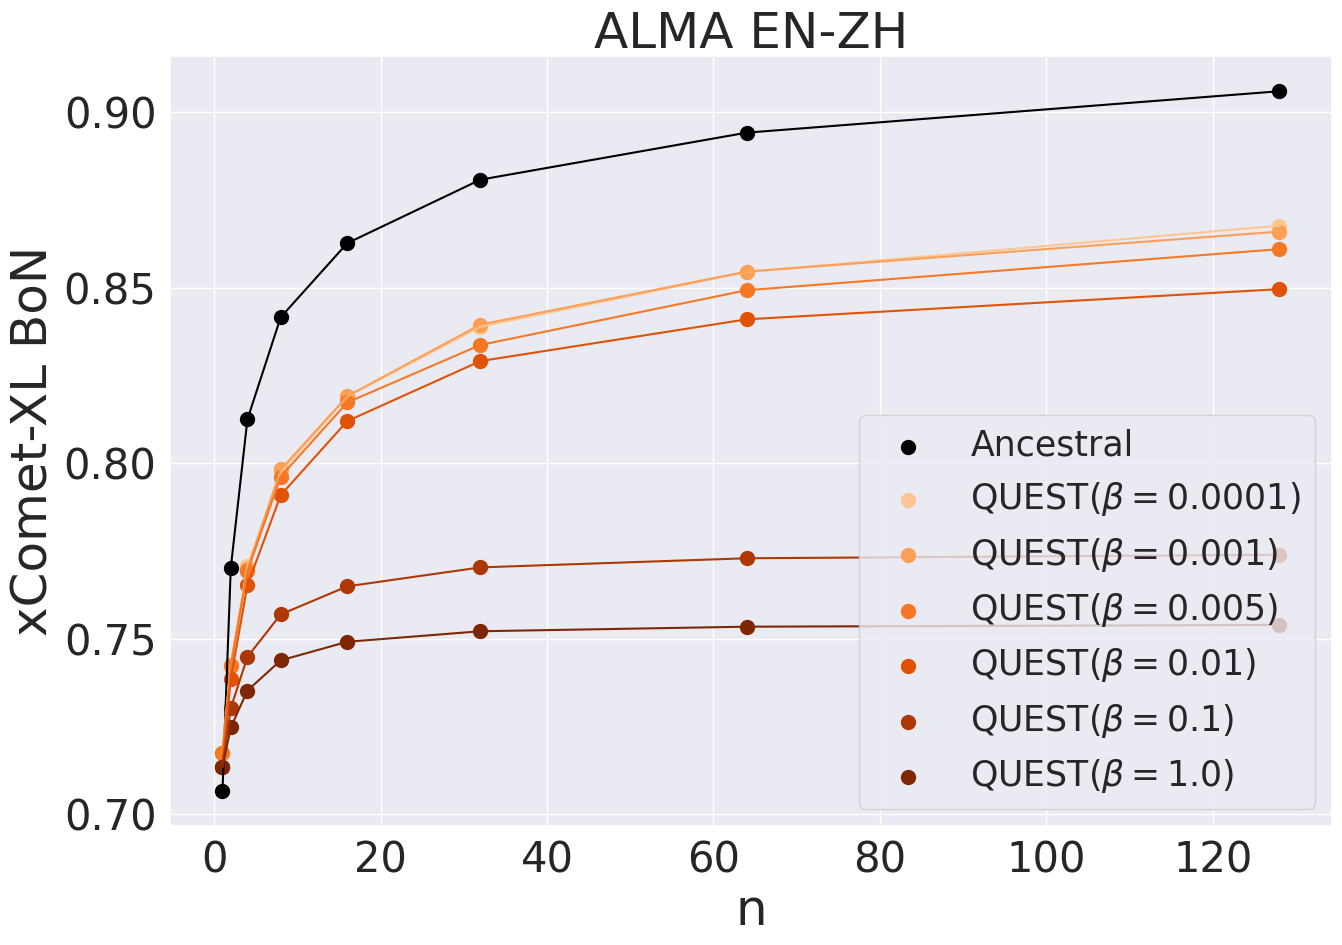

In [104]:
betasymb =r'$\beta=$' 
plot_graph(
    Ancestral=base[0],
    # quest_BoN=quest[0],
    # rlhf_BoN=rlhf[0],
    # free_proposal=proposal[0],
    # quest=quest[0],
    # compute_adjusted_quest=quest[0],
    # rlhf=rlhf[0],
    metric="max-reward",
    **{
        f"QUEST({betasymb}{e.meta['beta']})": e
        for e in quest
    },
    show=True,
    lw="--",
)

base_BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7064862871016577, 0.7093030778636281, 0.7100765393293546, 0.7100587854388277, 0.7107436221973821, 0.710835753219929, 0.7111028609290322, 0.7112187245249477]
quest- 0.0001-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7173798108822814, 0.7269314759799289, 0.7413447475944185, 0.7577158216901891, 0.7752773832753543, 0.7927187097368321, 0.8087339908300988, 0.8109855459099227]
quest- 0.001-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7173798176898274, 0.7267977107628792, 0.7397488905906626, 0.7565893916698638, 0.7738984089626408, 0.7910017195210519, 0.8076065174244893, 0.8109299620920654]
quest- 0.005-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.7173798191878467, 0.7260445810044859, 0.7390794526912638, 0.754481470161518, 0.7704357218072472, 0.7849583897271207, 0.7983931334240905, 0.8015177079906579]
quest- 0.01-B

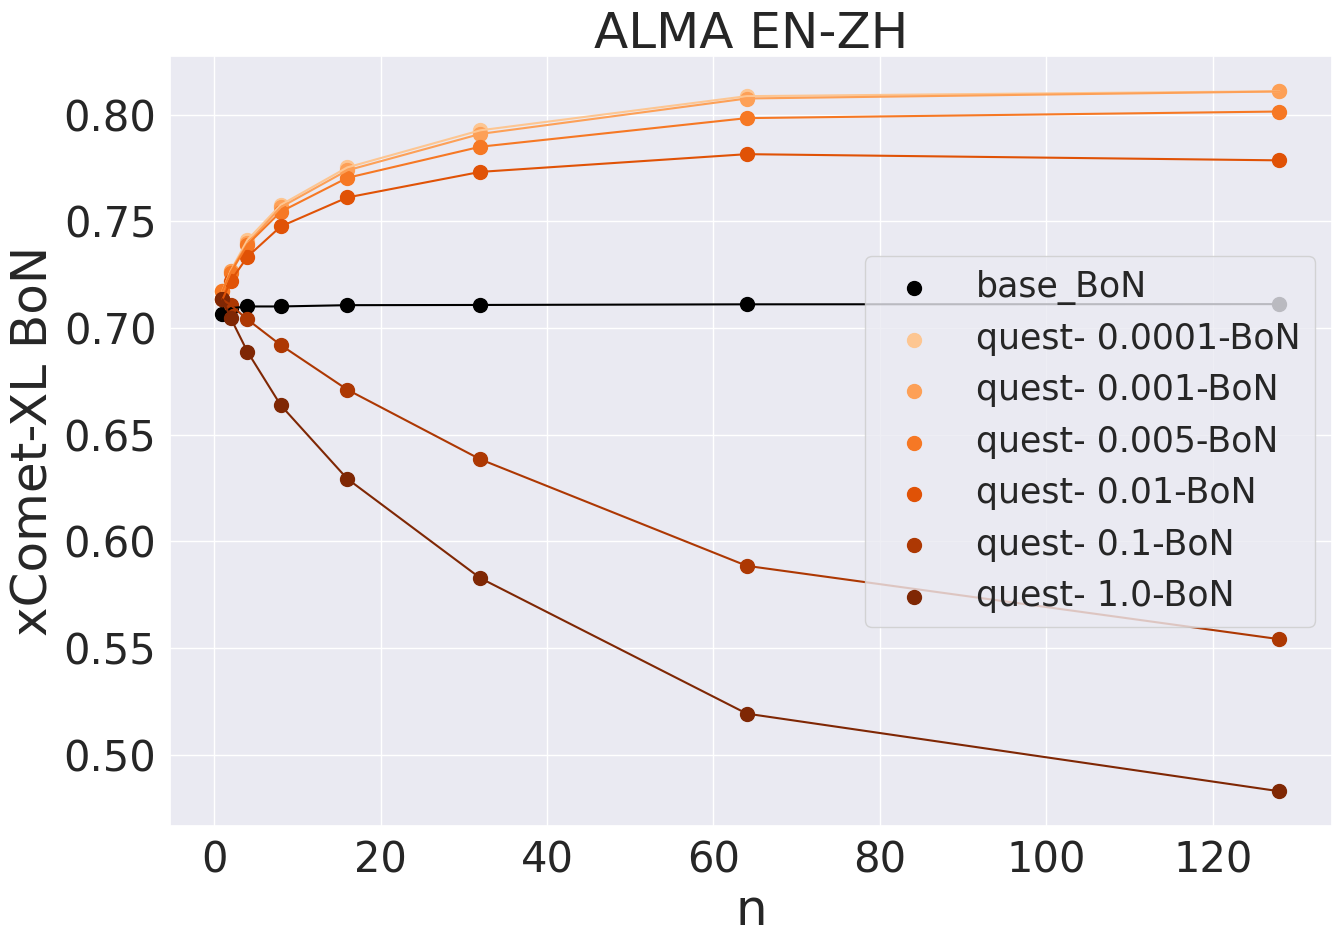

In [105]:
plot_graph(
    base_BoN=base[0],
    # quest_BoN=quest[0],
    # rlhf_BoN=rlhf[0],
    # free_proposal=proposal[0],
    # quest=quest[0],
    # compute_adjusted_quest=quest[0],
    # rlhf=rlhf[0],
    metric="mean-reward",
    **{
        f"quest- {e.meta['beta']}-BoN": e
        for e in quest
    },
    show=True,
    lw="--",
)

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

sns.set_theme()

# sns.set(rc={"figure.figsize": (15, 10)})
sns.set(
    style="darkgrid",
    rc={
        "grid.alpha": 1,
        "grid.linewidth": "1",
    },
)
sns.set_context(
    font_scale=2.5,
    rc={"lines.linewidth": 4.5},
)

sns.set(font_scale=3)
import numpy as np
import pandas as pd

def plot_pareto_graph(
    comparisons,
    x_name,
    y_name,
    title,
    y_label=None,
    x_label=None,
    xlim=None,
    ylim=None,
):
    plt.figure(figsize=(15, 10))
    plt_data = []
    for (
        method,
        experiments,
    ) in comparisons.items():

        for exp in experiments:
            try:

                print(exp.ops_results)
                x = exp.ops_results[
                    x_name
                ]
                y = exp.ops_results[
                    y_name
                ]
                plt_data.append(
                    [
                        method,
                        exp.meta[
                            "temperature"
                        ],
                        x,
                        y,
                    ]
                )
            except Exception as e:
                print(e)
                pass

                # plt_data.append([method + f"-beta{exp.meta.get('beta', '')}", exp.meta["temperature"], x, y])
    plot_df = pd.DataFrame(plt_data)

    print(plt_data)

    plot_df.columns = [
        "Method",
        "τ",
        x_name,
        y_name,
    ]

    name_dict = {
        #"nucleus": "Nucleus",
        #"beam_sample": "Beam Sample",
        "ancestral": "Ancestral",
        "quest": "QUEST",
        #"mcmc-qe-rlhf": "QUEST-RLHF",
    }
    plot_df["Method"] = plot_df[
        "Method"
    ].apply(lambda x: name_dict[x])
    plot_df = plot_df[
        plot_df.Method.isin(
            [
                "Ancestral",
                "QUEST",
                #"QUEST-RLHF",
            ]
        )
    ]
    plot_df = plot_df.sort_values(
        by=[x_name]
    )

    plot_df["Method"] = pd.Categorical(
        plot_df["Method"],
        categories=[
            "QUEST",
            "Ancestral",
            # "QUEST-RLHF",
        ],
        ordered=True,
    )
    plot_df = plot_df.sort_values(
        by=["Method"]
    )

    plot_df[y_name] = plot_df[y_name] * 100
    plot_df[x_name] = plot_df[x_name] * 100
    # print(plot_df.head())

    ax = sns.scatterplot(
        plot_df,
        x=x_name,
        y=y_name,
        hue="Method",
        legend="brief",
        s=500,
    )
    ax = sns.lineplot(
        plot_df,
        x=x_name,
        y=y_name,
        hue="Method",
        legend=None,
    )

    # for method in plot_df.method.unique():
    #    xqd, yqd = fit_quadratic(plot_df[plot_df["method"]==method][x_name].to_list(), plot_df[plot_df["method"]==method][y_name].to_list())
    #    plt.plot(xqd, yqd)

    # plt.axhline(plot_df[(plot_df.Method=='ancestral') & (plot_df["τ"]==0.8)][y_name].values[0], linestyle="-.", color="black", linewidth=1)
    # plt.axvline(plot_df[(plot_df.Method=='ancestral') & (plot_df["τ"]==0.8)][x_name].values[0], linestyle="-.", color="black", linewidth=1)
    # plt.legend('',frameon=False)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.legend(loc='lower left', fontsize = 36)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label, fontsize=36)
    plt.ylabel(y_label, fontsize=36)

    # if xlim is not None:
    # plt.xlim(30, 80)

    # if ylim is not None:
    # plt.ylim(65, 90)

    plt.title(title, fontsize=40)
    plt.show()
    # plt.show()

    # plt.savefig(file_name)

{'diversity': 0.6964049800543085, 'mean-reward-1': 0.7173798108822814, 'mean-reward-2': 0.7269314759799289, 'mean-reward-4': 0.7413447475944185, 'mean-reward-8': 0.7577158216901891, 'mean-reward-16': 0.7752773832753543, 'mean-reward-32': 0.7927187097368321, 'mean-reward-64': 0.8087339908300988, 'mean-reward-128': 0.8109855459099227, 'last-reward-1': 0.7173798108822814, 'last-reward-2': 0.7364831410775763, 'last-reward-4': 0.7601922033472542, 'last-reward-8': 0.780691090469176, 'last-reward-16': 0.8007116768356689, 'last-reward-32': 0.8166662344358064, 'last-reward-64': 0.8304879219798998, 'last-reward-128': 0.8415809762954366, 'max-reward-1': 0.7173798108822814, 'max-reward-2': 0.742608849988724, 'max-reward-4': 0.770841436872027, 'max-reward-8': 0.7973504013870208, 'max-reward-16': 0.8189909328413101, 'max-reward-32': 0.8388794401386894, 'max-reward-64': 0.8545226282824546, 'max-reward-128': 0.8677131797175858}
{'diversity': 0.6687337117313525, 'mean-reward-1': 0.7173798176898274, 'me

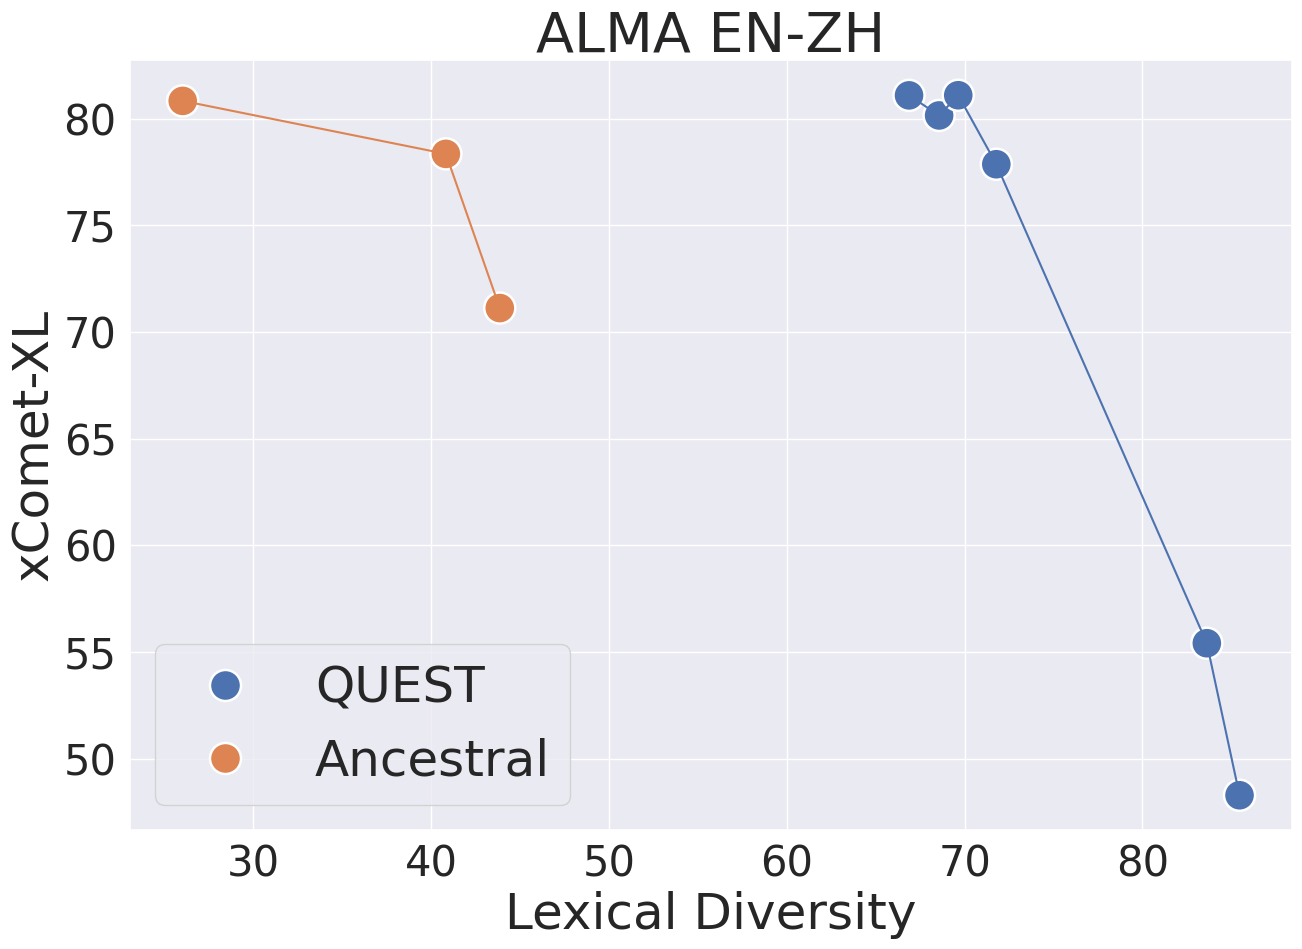

In [107]:
plot_pareto_graph(
    {"quest": quest, "ancestral": base},
    "diversity",
    "mean-reward-128",
    f"ALMA {LP.upper()}",
    y_label="xComet-XL",
    x_label=f"Lexical Diversity",
    xlim=None,
    ylim=None,
)

In [108]:
snd = list(
    map(
        proj("text"), b.instances[1].outputs
    )
)
print(snd[0])
#print(b.evals["qe:Unbabel-XCOMET-XL"][0].results["scores"][0])
print(set(snd))

NameError: name 'b' is not defined

In [ ]:
def get_reproduce_samples(q):
    return [[o["text"] for o in q.instances[0].outputs if o["accept"] ] for i in q.instances]

reproduce_samples =get_reproduce_samples(q)
#print(set(reproduce_samples))
print(len(reproduce_samples))

# 

1000


In [ ]:
set(b.evals["qe:Unbabel-XCOMET-XL"][0].results["scores"])

{0.876561164855957, 0.8837606310844421, 0.988223671913147}

In [ ]:
set(
    q.evals["qe:Unbabel-XCOMET-XL"][
        0
    ].results["scores"]
)

{0.7963482141494751,
 0.8596327304840088,
 0.8640736341476442,
 0.882412075996399,
 0.882440447807312,
 0.923823356628418,
 0.9343390464782715}